# What should I watch next?

Implementation of a movie recommendation system trained on the dataset [MovieLens100k](https://grouplens.org/datasets/movielens/100k/).

## Packages

In [ ]:
!pip install pympler
!pip install pyspark

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from scipy.sparse import find
from pympler import asizeof
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import lit
import bidict
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:
data_path = ""

## Exploratory Data Analysis and Preprocessing

In this section we want to get a feeling of the data and check if any data cleaning or preprocessing is required.
First, we load the data:

In [171]:
movies_path = data_path + "movies.csv"
ratings_path = data_path + "ratings.csv"

df_movies = pd.read_csv(movies_path)
df_ratings = pd.read_csv(ratings_path)

In [172]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [173]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Let us check if any missing value is present. 

In [174]:
df_ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

No missing values found. We also check for the movie dataset, albeit not essential:

In [175]:
df_movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

Again, no missing values. 

Let us check that no duplicate ratings have been added by mistake:

In [176]:
df_movies.duplicated().sum()

0

We can proceed with the analysis.

We recall that ratings are essentially an (ordinal) categorical variable with the following distribution:

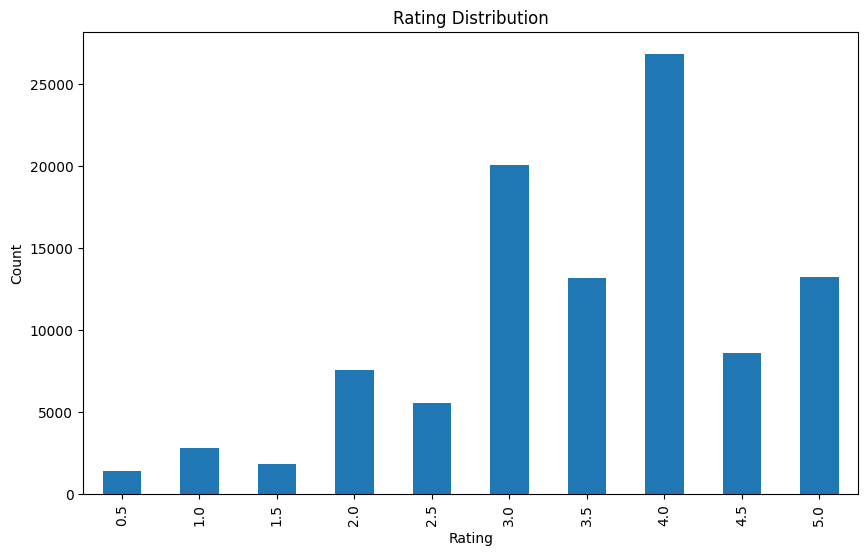

In [177]:
plt.figure(figsize=(10, 6))
df_ratings['rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Distribution')
plt.show()

For the sake of the implementation of ALS no particular data cleaning procedure is needed: we will not need to handle genres (which would be necessary instead if we implemented a content based recommender) and we will not need metadata on movies and ratings. 

We will however need some of this information for building the "small" example we will use for visualizing the algorithm, as we will clarify later. Hence, we clean the genre column in the movie dataset:

In [178]:
df_movies['genres'] = df_movies['genres'].str.split('|')
df_movies_ohe = df_movies.join(df_movies.pop('genres').str.join('|').str.get_dummies())
df_movies_ohe.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's have a look at the number of users and movies.

In [179]:
n_movies = df_movies_ohe.shape[0]
n_users = df_ratings['userId'].nunique()
print(f'Number of movies: {n_movies}')
print(f'Number of users: {n_users}')

Number of movies: 9742
Number of users: 610


Of course, it wouldn't make sense to get rid of certain users before applying our algorithms: we want to be able to make recommendations for all our users, and all of them have a non-negligible minimum amount of ratings anyway:

In [180]:
user_freq = df_ratings['userId'].value_counts()
user_freq = user_freq.sort_values(ascending=False)
user_freq.describe()

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: count, dtype: float64

On the contrary, we may look into the distribution of the ratings by movie:

In [181]:
movie_freq = df_ratings['movieId'].value_counts()
movie_freq = movie_freq.sort_values(ascending=False)
movie_freq.describe()

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: count, dtype: float64

Notice the median number of ratings per movie: 3. 
It is true that we aim at making recommendations that do not suffer from a popularity bias (i.e. we want to avoid to recommend only popular movies to everyone), but to make things more manageable and provide meaningful recommendations we could have chosen to drop all movies with less than 3 reviews. After all, with thousands of possible movies to choose from we wouldn't want our recommendations to rely on movies with only a handful of reviews. 

This choice would have clearly affected the likelihood of recommending movies that have been only recently added to our library, but we believe this instance should rather be handled separately with a recommender for a "what's new?" or a "trending now" section of our recommendation website or streaming service. For movies that have been for a long time on the platform but only have a handful reviews, we can safely assume that they are "niche" items, which are likely to be specifically searched for by the few interested users.

In [182]:
df_ratings.shape[0]

100836

In [183]:
min_movie_ratings = 6
filter_movies = movie_freq[movie_freq >= min_movie_ratings].index
df_ratings = df_ratings[df_ratings['movieId'].isin(filter_movies)]
df_ratings.shape[0]

88364

It's hardly noticeable in terms of total number of ratings of course, but it significanly lowers the movies dimension (making the user-item matrix belong to a much smaller space). To explicitly refer to the notation of the report of the project:
$$
R\in\mathbb{R}^{n\times m} \longrightarrow R\in\mathbb{R}^{n\times m'} \text{ where } m'\approx\frac{m}{2}
$$

For the user-item matrix, we can also get rid of the timestamp column (which indicates the time at which a rating was given).

In [184]:
df_ratings = df_ratings.drop('timestamp', axis=1)
filtered_path = data_path + "filtered_ratings.csv"
df_ratings.to_csv(filtered_path, index=False)

Let us now create the user-item matrix by pivoting the current dataframe of ratings.

In [185]:
user_item_matrix = df_ratings.pivot(index='userId', columns='movieId', values='rating', )
user_item_matrix.fillna(0, inplace=True)
print(f"Shape of user-item matrix: {user_item_matrix.shape}")
user_item_matrix.iloc[0:9, 0:9]

Shape of user-item matrix: (610, 3268)


movieId,1,2,3,4,5,6,7,8,9
userId,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,4.0,5.0,3.0,5.0,4.0,4.0,3.0,0.0
7,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Despite the fact that the sparsity effect has been mitigated by our filtering on "niche" movies, it is indeed a sparse matrix:

In [186]:
p = df_ratings.shape[0] / (user_item_matrix.shape[0] * user_item_matrix.shape[1])
print("Proportion of matrix filled:", p)

Proportion of matrix filled: 0.04432650440435821


Le us plot the drastic decrease in the magnitude of the singular values, supporting our case for a latent space of lower dimension that can grasp and explain most of the variability of the data.

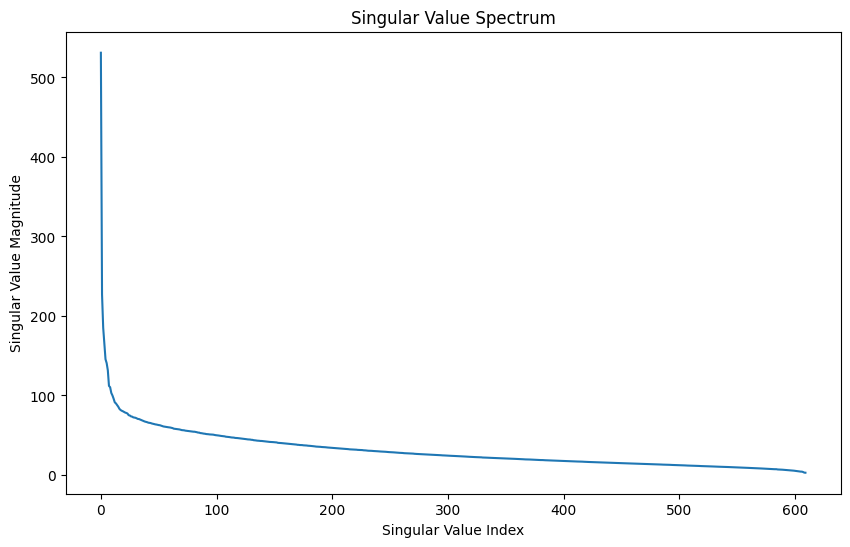

In [187]:
# plot on the magnitude of the singular values of the user-item matrix compared to their number (eg.: magnitude of the first singular value, magnitude of the second singular value, etc.)
U, s, Vt = np.linalg.svd(user_item_matrix, full_matrices=False)

plt.figure(figsize=(10, 6))
plt.plot(s)
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value Magnitude')
plt.title('Singular Value Spectrum')
plt.show()

# ALS: the classes

We implemented two classes for this algorithm:

* UserItemMatrix is a class representing a user-item rating matrix, which given a csv rating file builds a sparse or dense representation. It's designed to interact well with the second class, in terms of the way id's and indices are handled.
* ALS_WR is the class to implement the Alternating Least Square method with Weighted Regularization, as explained in the project. It allows for training for a fixed number of epochs, or using a validation set for early stopping.



In [188]:
class UserItemMatrix():
    """
    Class representing a user-item matrix for a movie recommendation system.
    Allows for a sparse and a dense representation of the user-item matrix.

    Parameters:
    - ratings_path (str): Path to the ratings data file.
    - movie_path (str): Path to the movie data file.
    - sparse (bool): Flag indicating whether to create a sparse user-item matrix (default: True).

    Attributes:
    - sparse (bool): Flag indicating whether the user-item matrix is sparse.
    - ratings_path (str): Path to the ratings data file.
    - movie_path (str): Path to the movie data file.
    - user_item_matrix (ndarray): Dense user-item matrix.
    - user_item_matrix_csr (csr_matrix): Sparse user-item matrix in CSR format.
    - user_item_matrix_csc (csc_matrix): Sparse user-item matrix in CSC format.
    - shape (tuple): Shape of the user-item matrix.
    - movie_bidict (DataFrame): bidict for converting movie ID to movie index.
    - movie_table (DataFrame): Table linking movie ID to movie title.
    - user_id_bidict (DataFrame): bidict for converting user ID to user Name.

    Methods:
    - shape: Get the shape of the user-item matrix.
    - get_movie_id: Get the movie ID corresponding to a given movie index.
    - get_movie_idx: Get the movie index corresponding to a given movie ID.
    - get_movie_name: Get the movie name corresponding to a given movie ID or index.
    - get_user_id: Get the user ID corresponding to a given user index.
    - get_user_idx: Get the user index corresponding to a given user ID.
    - user_ratings: Get the ratings of a given user.
    - movie_ratings: Get the ratings of a given movie.
    - get_user_table: Get the user table.
    - get_movie_table: Get the movie table.
    - get_user_item_matrix: Get the user-item matrix.
    - nnz_count: Get the number of non-zero elements in the user-item matrix.
    - nnz_by_user: Get the number of non-zero elements for each user.
    - nnz_by_movie: Get the number of non-zero elements for each movie.
    - mean_of_ratings: Get the mean rating value.
    - where_nnz_user: Get the indices of non-zero elements for a given user.
    - where_nnz_movie: Get the indices of non-zero elements for a given movie.
    - get_rating_path: Get the path to the ratings data file.
    - get_movie_path: Get the path to the movie data file.
    """

    def __init__(self, ratings_path, movie_path, sparse=True):
        """
        Initialize the UserItemMatrix object.

        Parameters:
        - ratings_path (str): The file path to the ratings data.
        - movie_path (str): The file path to the movie data.
        - sparse (bool, optional): Whether to use a sparse representation for the user-item matrix. 
                                   Defaults to True.

        """
        self.sparse = sparse
        self.ratings_path = ratings_path
        self.movie_path = movie_path

        if sparse:
            self._create_sparse_user_item_matrix(ratings_path)
            self.shape = self.user_item_matrix_csr.shape
        else:
            self._create_dense_user_item_matrix(ratings_path)
            self.shape = self.user_item_matrix.shape

        # lookup tables for idx's vs id's
        self._create_movie_table(movie_path, ratings_path)
        self._create_user_table(ratings_path)


    def _create_dense_user_item_matrix(self, ratings_path):
        """
        Submethod of the constructor.
        Create a dense user-item matrix from the ratings data.

        Raises:
        - ValueError: If userId, movieId, or rating columns are missing in the ratings data.
        - ValueError: If userId or movieId are not unique.

        """
        df_ratings = pd.read_csv(ratings_path)
        # check that userId, movieId and rating columns are present in df_ratings
        if not all(col in df_ratings.columns for col in ["userId", "movieId", "rating"]):
            raise ValueError("userId, movieId, and rating columns are required in df_ratings.")
        
        # check that userId and movieId are unique
        if not df_ratings[['userId', 'movieId']].duplicated().sum() == 0:
            raise ValueError("userId and movieId should be unique.")
        
        # create user item matrix
        self.user_item_matrix = df_ratings.pivot(index='userId', columns='movieId', values='rating')
        # fill missing values with 0
        self.user_item_matrix.fillna(0, inplace=True)

        # store only array values
        self.user_item_matrix = self.user_item_matrix.values

        return


    def _create_sparse_user_item_matrix(self, ratings_path):
        """
        Submethod of the constructor.
        Create a sparse user-item matrix from the ratings data.
        It stores the matrix in both CSR and CSC formats for fast slicing.

        Raises:
        - ValueError: If userId, movieId, or rating columns are missing in the ratings data.
        - ValueError: If userId or movieId are not unique.
        """
        df_ratings = pd.read_csv(ratings_path)
        # check that userId, movieId and rating columns are present in df_ratings
        if not all(col in df_ratings.columns for col in ["userId", "movieId", "rating"]):
            raise ValueError("userId, movieId, and rating columns are required in df_ratings.")
        
        # check that userId and movieId are unique
        if not df_ratings[['userId', 'movieId']].duplicated().sum() == 0:
            raise ValueError("userId and movieId should be unique.")
        
        # create user item matrix, but first we need to reset the index
        # substitute userId and movieId with new indexes
        df_ratings['userId'] = df_ratings['userId'].astype('category').cat.codes
        df_ratings['movieId'] = df_ratings['movieId'].astype('category').cat.codes
        self.user_item_matrix_csr = csr_matrix((df_ratings['rating'], (df_ratings['userId'], df_ratings['movieId'])))
        self.user_item_matrix_csc = self.user_item_matrix_csr.tocsc()
        return
    

    def _create_movie_table(self, movie_path, ratings_path):
        """
        Create a dict and a movie table based on the provided movie and ratings data.
        Used to map movie indices to movie IDs and titles.
        """
        df_movies = pd.read_csv(movie_path)
        df_ratings = pd.read_csv(ratings_path)

        # Check that movieId and title columns are present in df_movies
        if not all(col in df_movies.columns for col in ["movieId", "title"]):
            raise ValueError("movieId and title columns are required in df_movies.")

        # Store an array with numerical index, movieId, and title
        self.movie_table = df_movies[['movieId', 'title']]
        # Subset for movies in ratings
        self.movie_table = self.movie_table[self.movie_table['movieId'].isin(df_ratings['movieId'].unique())]
        # Reset indices
        self.movie_table.reset_index(inplace=True)
        # dictionary with movieId as key and index as value
        self.movie_dict = dict(zip(self.movie_table['movieId'], self.movie_table.index))
        return
    
    def _create_user_table(self, ratings_path):
        """
        Create a user lookup table from the ratings data (in the form of a bidict).
        Used to map user indices to user IDs.
        """
        df_ratings = pd.read_csv(ratings_path)
        user_table = df_ratings[['userId']].drop_duplicates().reset_index(drop=True)
        self.user_id_bidict = bidict.bidict()
        for idx, row in user_table.iterrows():
            self.user_id_bidict[row['userId']] = idx
        return
    
    def get_movie_id(self, movie_idx):
        """
        Method to get the movie ID corresponding to a given movie index.
        """
        return self.movie_table.iloc[movie_idx]['movieId']
        
    def get_movie_idx(self, movie_id):
        """
        Method to get the movie index corresponding to a given movie ID.
        """
        return self.movie_dict[movie_id]
        
    def get_movie_name(self, movie_id, from_idx = False):
        """
        Method to get the movie name corresponding to a given movie ID or index.
        """
        if from_idx:
            return self.movie_table["title"][movie_id]
        else:
            idx = self.get_movie_idx(movie_id)
            return self.movie_table["title"][idx]

    def get_user_id(self, user_idx):
        """
        Method to get the user ID corresponding to a given user index.
        """
        return self.user_id_bidict.inv[user_idx]
    
    def get_user_idx(self, user_id):
        """
        Method to get the user index corresponding to a given user ID.
        """
        return self.user_id_bidict[user_id]
    
    def user_ratings(self, user_id, nnz=True):
        """
        Method to get the ratings of a given user.
        Either returns the full user-item row or only the non-zero ratings.
        """
        if self.sparse:
            user_idx = self.get_user_idx(user_id)
            if nnz:
                # return only non zero ratings
                _, _, ratings = find(self.user_item_matrix_csr[user_idx])
                return ratings
            else:
                return self.user_item_matrix_csr[user_idx].toarray().reshape(-1)
        else:
            user_idx = self.get_user_idx(user_id)
            if nnz:
                return self.user_item_matrix[user_idx][self.user_item_matrix[user_idx] > 0]
            else:
                return self.user_item_matrix[user_idx]
        
    def movie_ratings(self, movie_id, nnz=True):
        """
        Method to get the ratings of a given movie.
        Either returns the full user-item column or only the non-zero ratings.
        """
        movie_idx = self.get_movie_idx(movie_id)
        if self.sparse:
            if nnz:
                # return only non zero ratings
                _, _, ratings = find(self.user_item_matrix_csc[:, movie_idx])
                return ratings
            else:
                return self.user_item_matrix_csc[:, movie_idx].toarray().reshape(-1)
        else:
            if nnz:
                return self.user_item_matrix[self.user_item_matrix[:, movie_idx] > 0, movie_idx]
            else:
                return self.user_item_matrix[:, movie_idx]
        
    def get_user_table(self):
        return self.user_table
    
    def get_movie_table(self):
        return self.movie_table
    
    def get_user_item_matrix(self):
        """
        Method to get the user-item matrix, as a dataframe with user_id's and movie_id's indices.
        """
        if self.sparse:
            uim = pd.DataFrame(self.user_item_matrix_csr.todense())
        else:
            uim = pd.DataFrame(self.user_item_matrix)
        # switch rows index to userId
        uim.index = self.user_id_bidict.inv
        # switch columns index to movieId
        uim.columns = self.movie_table['movieId']
        return uim
    
    def nnz_count(self):
        """
        Method to get the number of non-zero elements in the user-item matrix.
        """
        if self.sparse:
            return self._sparse_nnz_count()
        else:
            return self._dense_nnz_count()

    def _dense_nnz_count(self):
        return np.count_nonzero(self.user_item_matrix)

    def _sparse_nnz_count(self):
        return self.user_item_matrix_csr.nnz
    
    def nnz_by_user(self, user_id=None):
        """
        Method to get the number of non-zero elements for each user.
        If user_id is provided, it returns the number of non-zero elements for that user.
        Else, it returns the number of non-zero elements for each user.
        """
        if self.sparse:
            return self._sparse_nnz_by_user(user_id)
        else:
            return self._dense_nnz_by_user(user_id)
        
    def _dense_nnz_by_user(self, user_id=None):
        if user_id is None:
            return np.count_nonzero(self.user_item_matrix, axis=1)
        else:
            user_idx = self.get_user_idx(user_id)
            return np.count_nonzero(self.user_item_matrix[user_idx])
        
    def _sparse_nnz_by_user(self, user_id=None):
        if user_id is None:
            return self.user_item_matrix_csr.getnnz(axis=1)
        else:
            user_idx = self.get_user_idx(user_id)
            return self.user_item_matrix_csr[user_idx].getnnz()
    
    def nnz_by_movie(self, movie_id=None):
        """
        Method to get the number of non-zero elements for each movie.
        If movie_id is provided, it returns the number of non-zero elements for that movie.
        Else, it returns the number of non-zero elements for each movie.
        """
        if self.sparse:
            return self._sparse_nnz_by_movie(movie_id)
        else:
            return self._dense_nnz_by_movie(movie_id)
        
    def _dense_nnz_by_movie(self, movie_id=None):
        if movie_id is None:
            return np.count_nonzero(self.user_item_matrix, axis=0)
        else:
            movie_idx = self.get_movie_idx(movie_id)
            return np.count_nonzero(self.user_item_matrix[:, movie_idx])
    
    def _sparse_nnz_by_movie(self, movie_id=None):
        if movie_id is None:
            return self.user_item_matrix_csc.getnnz(axis=0)
        else:
            movie_idx = self.get_movie_idx(movie_id)
            return self.user_item_matrix_csc[:, movie_idx].getnnz()
        
    def mean_of_ratings(self, axis=None):
        """
        Method to get the mean rating value.
        If axis is None, it returns the mean of all ratings.
        If axis is 0, it returns the mean rating value for each movie.
        If axis is 1, it returns the mean rating value for each user.
        """
        if self.sparse:
            return self._sparse_mean_of_ratings(axis)
        else:
            return self._dense_mean_of_ratings(axis)
        
    def _dense_mean_of_ratings(self, axis):
        if axis is None:
            return np.mean(self.user_item_matrix[self.user_item_matrix != 0])
        else:
            return np.mean(self.user_item_matrix, axis=axis)
    
    def _sparse_mean_of_ratings(self, axis):
        if axis is None:
            return self.user_item_matrix_csr.sum() / self.user_item_matrix_csr.nnz
        else:
            if axis == 0:
                tmp = self.user_item_matrix_csc.mean(axis=axis) 
                return np.array(tmp).reshape(-1)
            elif axis == 1:
                tmp = self.user_item_matrix_csr.mean(axis=axis) 
                return np.array(tmp).reshape(-1)
            else:
                raise ValueError("axis should be 0, 1 or None")

    def where_nnz_user(self, user_id):
        """
        Method to get the indices of non-zero elements for a given user.
        """
        if self.sparse:
            return self._sparse_where_nnz_user(user_id)
        else:
            return self._dense_where_nnz_user(user_id)
        
    def _dense_where_nnz_user(self, user_id):
        user_idx = self.get_user_idx(user_id)
        return self.user_item_matrix[user_idx].nonzero()[0]
    
    def _sparse_where_nnz_user(self, user_id):
        user_idx = self.get_user_idx(user_id)
        return self.user_item_matrix_csr[user_idx].indices
    
    def where_nnz_movie(self, movie_id):
        """
        Method to get the indices of non-zero elements for a given movie.
        """
        if self.sparse:
            return self._sparse_where_nnz_movie(movie_id)
        else:
            return self._dense_where_nnz_movie(movie_id)
        
    def _dense_where_nnz_movie(self, movie_id):
        movie_idx = self.get_movie_idx(movie_id)
        return self.user_item_matrix[:, movie_idx].nonzero()[0]
    
    def _sparse_where_nnz_movie(self, movie_id):
        movie_idx = self.get_movie_idx(movie_id)
        return self.user_item_matrix_csc[:, movie_idx].indices
    
    def get_rating_path(self):
        return self.ratings_path
    
    def get_movie_path(self):
        return self.movie_path
    

In [189]:
class ALS_WR():
    """
    Alternating Least Squares with Regularization for collaborative filtering.
    The model is trained using the user-item matrix and the latent factors are learned.

    Parameters:
    - user_item_matrix (UserItemMatrix): UserItemMatrix object containing the user-item matrix.
    - factor_dim (int): Number of latent factors (default: 100).
    - seed (int): Seed for the random number generator (default: 42).

    Attributes:
    - user_item_matrix (UserItemMatrix): UserItemMatrix object containing the user-item matrix.
    - n_ratings (int): Number of ratings in the user-item matrix.
    - n_users (int): Number of users in the user-item matrix.
    - n_movies (int): Number of movies in the user-item matrix.
    - n_factors (int): Number of latent factors.
    - user_factors (ndarray): User latent factors.
    - movie_factors (ndarray): Movie latent factors.
    - reg_param (float): Regularization parameter.
    - n_iter (int): Number of iterations.
    - validation_path (str): Path to the validation data file.
    - patience (int): Number of iterations without improvement before stopping.
    - patience_counter (int): Counter for the early stopping mechanism.
    - training_loss (list): Training loss values.
    - validation_loss (list): Validation loss values.
    - best_loss (float): Best validation loss value.

    Methods:
    - fit: Train the model using ALS with regularization.
    - predict_rating: Predict the rating for a given user and movie.
    - recommend: Recommend movies for a given user.
    - get_factors: Get the user and movie latent factors.
    - get_loss: Get the training loss values.
    - get_validation_loss: Get the validation loss values.
    - get_best_loss: Get the best validation loss value.
    - evaluate: Evaluate the model using the test data (computing the loss).
    """


    def __init__(self, user_item_matrix, factor_dim = 100, seed=42):
        """
        Initialize the ALS_WR object.

        Raise:
        - ValueError: If user_item_matrix is not an instance of UserItemMatrix.

        """
        # check is instance of UserItemMatrix class
        if not isinstance(user_item_matrix, UserItemMatrix):
            raise ValueError("Constructor requires a UserItemMatrix object.")
        
        self.user_item_matrix = user_item_matrix
        self.n_ratings = self.user_item_matrix.nnz_count()
        self.n_users = self.user_item_matrix.shape[0]
        self.n_movies = self.user_item_matrix.shape[1]
        self.n_factors = factor_dim

        np.random.seed(seed)
    

    def fit(self, n_iter = 10, reg_param=0.1, regularization = "weighted", validation_path = None, patience = 2):
        """
        Train the model using ALS with regularization.

        Parameters:
        - n_iter (int): Number of iterations (default: 10).
        - reg_param (float): Regularization parameter (default: 0.1).
        - regularization (str): Regularization type, either 'weighted' or 'l2' (default: 'weighted').
        - validation_path (str): Path to the validation data file (default: None).
        - patience (int): Number of iterations without improvement before stopping (default: 2).
        """
        
        self.reg_param = reg_param
        self.n_iter = n_iter 
        self.validation_path = validation_path
        self.patience = patience
        self.patience_counter = 0

        self._init_regularization(regularization)
        self._init_latent_factors()
        self._train()
    

    def _init_regularization(self, regularization):
        # initialize regularization matrices
        if regularization == "weighted":
            # compute vector of number of ratings per user
            n_ratings_user = self.user_item_matrix.nnz_by_user()
            self.reg_matrix_user = np.diag(np.sqrt(n_ratings_user))
            # compute vector of number of ratings per movie
            n_ratings_movie = self.user_item_matrix.nnz_by_movie()
            self.reg_matrix_item = np.diag(np.sqrt(n_ratings_movie))
        elif regularization == "l2":
            self.reg_matrix_user = np.eye(self.n_users)
            self.reg_matrix_item = np.eye(self.n_movies)
        else:
            raise ValueError("Regularization must be either 'weighted' or 'l2'.")
        return


    def _init_latent_factors(self):
        # initialize user and movie latent factors
        self.user_factors = np.zeros((self.n_users, self.n_factors))
        self.movie_factors = np.random.rand(self.n_factors, self.n_movies)
        # use average ratings in the first column
        self.movie_factors[0, :] = self.user_item_matrix.mean_of_ratings(axis=0)
        return


    def _train(self):
        """
        Train the model using ALS with regularization.
        """
        self.training_loss = []
        if self.validation_path is not None:
            self.validation_loss = []
            self._load_validation_data()
        else:
            self.validation_loss = None

        for i in range(self.n_iter):
            self._update_user_factors()
            self._update_movie_factors()
            self._compute_loss()
            if self.validation_path is not None:
                self._compute_validation_loss()
                if self._early_stopping(i):
                    print(f"Early stopping at iteration {i}.")
                    break
        return
    
    def _load_validation_data(self):
        self.validation_user_item_matrix = UserItemMatrix(
            self.validation_path, self.user_item_matrix.get_movie_path(), sparse=True
            )
        return

    def _update_user_factors(self):
        """
        Update user factors, movies are fixed.
        """
        for i in range(self.n_users):
            # get indices of non-zero ratings
            idx = self.user_item_matrix.where_nnz_user(self.user_item_matrix.get_user_id(i))
            # get movie factors
            V = self.movie_factors[:, idx]
            # get ratings
            r = self.user_item_matrix.user_ratings(self.user_item_matrix.get_user_id(i))
            # update user factors
            reg_i = self.reg_matrix_user[i,i]
            self.user_factors[i] = np.linalg.solve(V @ V.T + self.reg_param * reg_i, V @ r)
        return
    
    
    def _update_movie_factors(self):
        """
        Update movie factors, users are fixed.
        """
        for j in range(self.n_movies):
            # get indices of non-zero ratings
            idx = self.user_item_matrix.where_nnz_movie(self.user_item_matrix.get_movie_id(j))
            # get user factors
            U = self.user_factors[idx]
            # get ratings
            r = self.user_item_matrix.movie_ratings(self.user_item_matrix.get_movie_id(j))
            # update movie factors
            reg_j = self.reg_matrix_item[j,j]
            self.movie_factors[:, j] = np.linalg.solve(U.T @ U + self.reg_param * reg_j, U.T @ r)
        return

    
    def _compute_loss(self):
        """ 
        Compute the RMSE loss for the training data.
        """
        loss = 0
        for i in range(self.n_users):
            idx = self.user_item_matrix.where_nnz_user(self.user_item_matrix.get_user_id(i))
            V = self.movie_factors[:, idx]
            r = self.user_item_matrix.user_ratings(self.user_item_matrix.get_user_id(i))
            loss += np.sum((r - self.user_factors[i] @ V) ** 2)

        loss = loss / self.n_ratings
        loss = np.sqrt(loss) #empirical RMSE is computed

        self.training_loss.append(loss)
        return

    
    def _compute_validation_loss(self):
        """
        Compute the RMSE loss for the validation data.
        """
        loss = 0
        for i in range(self.validation_user_item_matrix.shape[0]):
            idx = self.validation_user_item_matrix.where_nnz_user(self.validation_user_item_matrix.get_user_id(i))
            V = self.movie_factors[:, idx]
            r = self.validation_user_item_matrix.user_ratings(self.validation_user_item_matrix.get_user_id(i))
            loss += np.sum((r - self.user_factors[i] @ V) ** 2)
        loss = loss / self.validation_user_item_matrix.nnz_count()
        loss = np.sqrt(loss)
        self.validation_loss.append(loss)
        return
    

    def _early_stopping(self, i):
        """
        Early stopping mechanism.
        """
        if i == 0:
            self.best_loss = self.validation_loss[i]
        else:
            if self.validation_loss[i] < self.best_loss:
                self.best_loss = self.validation_loss[i]
                self.patience_counter = 0
            else:
                self.patience_counter += 1
                if self.patience_counter == self.patience:
                    return True
        return False    
    
    
    def predict_rating(self, user_id, movie_id):
        """
        Predict the rating for a given user and movie.
        """
        user_idx = self.user_item_matrix.get_user_idx(user_id)
        movie_idx = self.user_item_matrix.get_movie_idx(movie_id)
        # difference between the global mean and the estimated one
        global_mean = self.user_item_matrix.mean_of_ratings()
        # compute the estimated rating matrix
        R_hat = self.user_factors[user_idx] @ self.movie_factors[:, movie_idx]
        # compute the mean of R_hat
        R_hat_mean = R_hat.mean()
        # compute the estimated rating
        return self.user_factors[user_idx] @ self.movie_factors[:, movie_idx] + global_mean - R_hat_mean
    

    def recommend(self, user_id, n=10, include_seen=False, print=True):
        """
        Recommend top n movies for a given user.

        Parameters:
        - user_id (int): User ID.
        - n (int): Number of movies to recommend (default: 10).
        - include_seen (bool): Flag to include movies already seen by the user (default: False).
        """
        user_idx = self.user_item_matrix.get_user_idx(user_id)
        ratings = self.user_factors[user_idx] @ self.movie_factors
        if include_seen:
            top_n = ratings.argsort()[-n:][::-1]
        else:
            idx = self.user_item_matrix.where_nnz_user(user_id)
            ratings[idx] = 0
            top_n = ratings.argsort()[-n:][::-1]
        if print:
            # print top n movie names
            for i in range(len(top_n)):
                print(f"Recommended {i+1}: {self.user_item_matrix.get_movie_name(top_n[i], from_idx=True)}")
        
        # return top n movie ids, not idxs
        return self.user_item_matrix.get_movie_id(top_n).values
    

    def get_factors(self):
        return self.user_factors, self.movie_factors
    

    def get_loss(self):
        return self.training_loss
    

    def get_validation_loss(self):
        return self.validation_loss
    

    def get_best_loss(self):
        return self.best_loss
    
    def evaluate(self, test_ui_matrix):
        """
        Evaluate the model using the test data.
        """
        n_ratings = test_ui_matrix.nnz_count()
        n_users = test_ui_matrix.shape[0]
        n_movies = test_ui_matrix.shape[1]
        loss = 0
        for i in range(n_users):
            idx = test_ui_matrix.where_nnz_user(test_ui_matrix.get_user_id(i))
            V = self.movie_factors[:, idx]
            r = test_ui_matrix.user_ratings(test_ui_matrix.get_user_id(i))
            loss += np.sum((r - self.user_factors[i] @ V) ** 2)
        loss = loss / n_ratings
        loss = np.sqrt(loss)
        return loss
    

We remark that a sparse representation is extremely convenient in terms of memory occupation. See, for example, the difference between the dense and sparse instances of our UserItemMatrix() classes based on MovieLens 100k: the dense representation requires more than 10 times the space.

Details about computational tradeoffs are in the project.

In [190]:
# paths
ratings_path = data_path + "ratings.csv"
movie_path = data_path + "movies.csv"

# Initialize both sparse and dense UserItemMatrix instances
uim_sparse = UserItemMatrix(ratings_path, movie_path, sparse=True)
uim_dense = UserItemMatrix(ratings_path, movie_path, sparse=False)

# Compute occupied space using pympler
sparse_storage_total = asizeof.asizeof(uim_sparse)
dense_storage_total = asizeof.asizeof(uim_dense)

# Print occupied space
print(f"Sparse UserItemMatrix total storage: {sparse_storage_total} bytes")
print(f"Dense UserItemMatrix total storage: {dense_storage_total} bytes")

del uim_sparse
del uim_dense

Sparse UserItemMatrix total storage: 5388376 bytes
Dense UserItemMatrix total storage: 50378392 bytes


# Understanding Matrix Factorization and Latent Factors in Recommender Systems

We have discussed in the report that the latent factors built by ALS essentially represent more or less interpretable and complicated movie features and the way each user may or may not appreciate them.

To clarify this heuristic, we construct a very small example based on real-life data we sampled (from a friend group) that fit our purpose.
Data is stored in the same format as the MovieLens data, and with the same kind of ratings.
We will consider 6 movies and 6 users, who rated all or some of them.
The goal will be:
- to illustrate how the matrix factorization works;
- to get an intuition behind what factors are meant to represent and what it means for ASL to compare them directly using the inner product.

In [191]:
# movies
movies_id = [0, 1, 2, 3, 4, 5]
user_id = [0, 1, 2, 3, 4, 5]
user_name = ["Fede", "Ale", "Ghido", "Lucio", "Vale", "Moni"]
movie_name = ["Forrest Gump", "Kill Bill", "Titanic", "Transformers 1", "Avengers", "LaLaLand"]

# create a movie dataset with movies_id and movie_name
movies = pd.DataFrame(list(zip(movies_id, movie_name)), columns=["movieId", "title"])
# store it in movies_small.csv
movies.to_csv("movies_small.csv", index=False)


fede_ratings = [0, 5, 2, 4, 4.5, 0]
ale_ratings = [0, 4.5, 4.5, 0, 3, 5]
ghido_ratings = [5, 5, 4, 5, 5, 3]
lucio_ratings = [0, 0, 1, 3, 4, 0]
vale_ratings = [4, 4, 0, 0, 1, 2]
moni_ratings = [0, 4, 1, 0, 1, 1]

user_item_matrix = np.array([fede_ratings, ale_ratings, ghido_ratings, lucio_ratings, vale_ratings, moni_ratings])
user_item_matrix = pd.DataFrame(user_item_matrix, columns=movies_id, index=user_id)
user_item_matrix

# stack it in the ratings format
ratings = user_item_matrix.stack().reset_index()
ratings.columns = ['userId', 'movieId', 'rating']
ratings.head()


,userId,movieId,rating
0,0,0,0.0
1,0,1,5.0
2,0,2,2.0
3,0,3,4.0
4,0,4,4.5


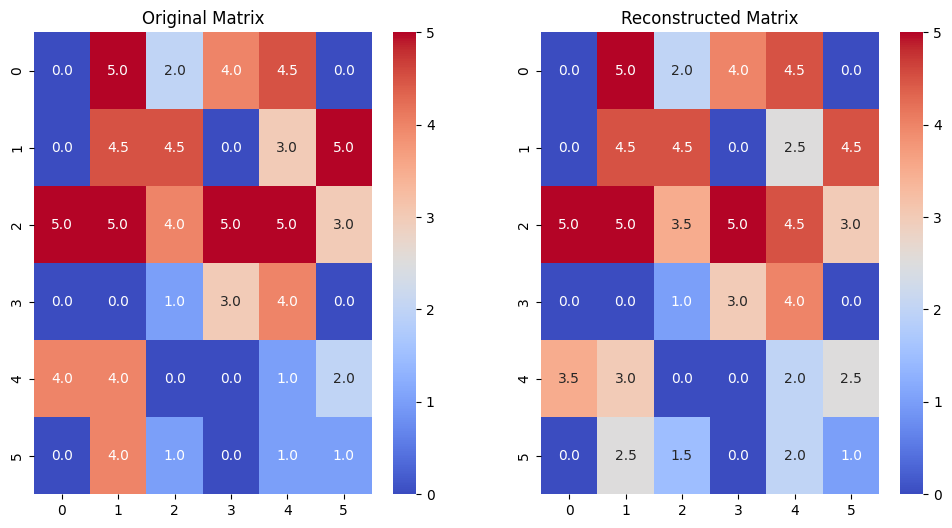

In [192]:
# drop rows with rating = 0
ratings = ratings[ratings['rating'] != 0]
# store in a csv file
ratings.to_csv(data_path + 'ratings_small.csv', index=False)

# paths
ratings_path = data_path + "ratings_small.csv"
movie_path = data_path + "movies_small.csv"

# Initialize UserItemMatrix instance
uim = UserItemMatrix(ratings_path, movie_path, sparse=True)

# Initialize ALS_WR instance
als = ALS_WR(uim, factor_dim=2)

# Train the model
als.fit(n_iter=10, reg_param=0.05, regularization="weighted")

# show the reconstructed matrix
reconstructed_matrix = als.user_factors @ als.movie_factors
# set values to zero if the original matrix has zero values
reconstructed_matrix[uim.get_user_item_matrix().values == 0] = 0
# round the reconstructed to the closest integer .5 value
reconstructed_matrix = np.round(reconstructed_matrix * 2) / 2
# clip values in [0,5]
reconstructed_matrix = np.clip(reconstructed_matrix, 0, 5)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(uim.get_user_item_matrix().values, cmap='coolwarm', cbar=True, annot = True, fmt=".1f")
plt.title('Original Matrix')
plt.subplot(1, 2, 2)
sns.heatmap(reconstructed_matrix, cmap='coolwarm', cbar=True, annot = True, fmt=".1f")
plt.title('Reconstructed Matrix')

plt.show()
plt.show()

The matrix has been weel reconstructed. Of course, it is not extremely accurate given the very low number of observations and factors considered.

By multiplying the factors we now get a different matrix, containing also the predicted ratings.

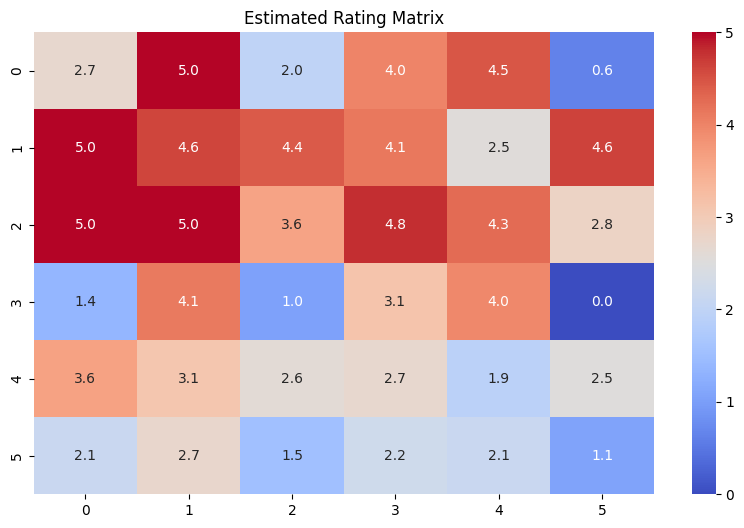

In [193]:
# heatmap (wiht values) of the estimated rating matrix
reconstructed_matrix = np.round(als.user_factors @ als.movie_factors, 2).clip(0, 5)
plt.figure(figsize=(10, 6))
sns.heatmap(reconstructed_matrix, cmap='coolwarm', cbar=True, annot = True, fmt=".1f")
plt.title('Estimated Rating Matrix')
plt.show()

The new ratings are not necessarily in the same interval as the original ones, but for the task of recommending the top N movies it doesn't affect us: we only care about the descending order between predicted ratings of unseen movies. we could simply clip them and approximate them to the closest acceptable rating if we ever needed to display them.

In [194]:
reconstructed_matrix = np.round(reconstructed_matrix * 2) / 2
reconstructed_matrix

array([[2.5, 5. , 2. , 4. , 4.5, 0.5],
       [5. , 4.5, 4.5, 4. , 2.5, 4.5],
       [5. , 5. , 3.5, 5. , 4.5, 3. ],
       [1.5, 4. , 1. , 3. , 4. , 0. ],
       [3.5, 3. , 2.5, 2.5, 2. , 2.5],
       [2. , 2.5, 1.5, 2. , 2. , 1. ]])

In [195]:
# get recommendation for user "fede" for unseen movies
fede_rec_idx = als.recommend(0, n=2, include_seen=False, print=False)
fede_rec = movies[movies['movieId'].isin(fede_rec_idx)]["title"]
print(f"Recommendation for user 'Fede': ")
for rec in fede_rec:
    print(f"- {rec}")

# get recommendation for user "Lucio" for unseen movies
lucio_rec = als.recommend(3, n=3, include_seen=False, print=False)
lucio_rec = movies[movies['movieId'].isin(lucio_rec)]["title"]
print(f"Recommendation for user 'Lucio': ")
for rec in lucio_rec:
    print(f"- {rec}")

Recommendation for user 'Fede': 
- Forrest Gump
- LaLaLand
Recommendation for user 'Lucio': 
- Forrest Gump
- Kill Bill
- Avengers


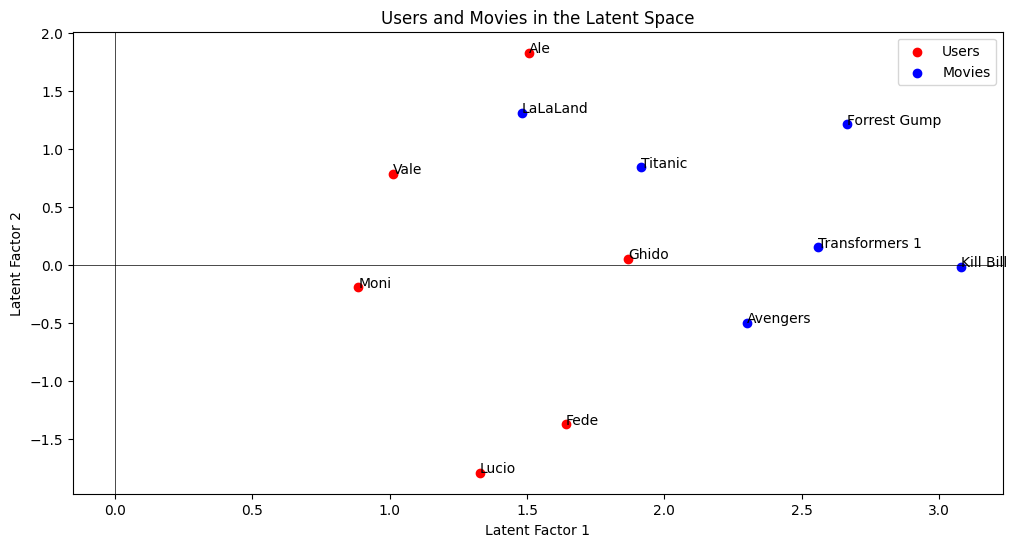

In [196]:
# plot movies and users latent factors
user_factors, movie_factors = als.get_factors()

plt.figure(figsize=(12, 6))
plt.scatter(user_factors[:, 0], user_factors[:, 1], c='r', label='Users')
plt.xlabel('Latent Factor 1')
plt.ylabel('Latent Factor 2')
plt.title('Users and Movies in the Latent Space')
plt.scatter(movie_factors[0], movie_factors[1], c='b', label='Movies')
plt.xlabel('Latent Factor 1')
plt.ylabel('Latent Factor 2')
# add user names
for i, txt in enumerate(user_name):
    plt.annotate(txt, (user_factors[i, 0], user_factors[i, 1]))
# add movie names
for i, txt in enumerate(movie_name):
    plt.annotate(txt, (movie_factors[0][i], movie_factors[1][i]))
# add axes
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.legend()
plt.show()


We can also try to give an intepretation to the factors as a sort of dimensionality reduction technique.

Recall that a predicted rating is given by the inner product between the user-point and the movie-point.
For example, factor 1 could refer to the level of action in a movie, or something related to that (which would explain the two "clusters"), whereas factor 2 could be related to how emotional the movie is.
Users' coordinates, tell us how they relate to this factors. For example, Ale values highly the emotional component, way more than the action. To Lucio instead, the emotional component of a movie lowers the score (since all factor 2 coordinates are positive for movies, but he has a negative coordinate instead).

Of course, this interpretation is somewhat stretched, but the point itself of matrix factorization instead of content based recommenders is to let factors handle the identification of aspects of movies and users that are relevant to compute ratings are not necessarily intuitive.

# A Proper Example of a Small Dataset

We illustrate how the algorithm works with a subset of the real data to show the validation procedure and an easy implementation of grid search.

In [197]:
# load data
ratings_path = data_path + "filtered_ratings.csv"
movie_path = data_path + "movies.csv"

# we reduce the size of the dataset
df_ratings = pd.read_csv(ratings_path)
# pick a random sample of users
np.random.seed(42)

n_ratings_per_movie = 50
# sort movies by most rated
movies_count = df_ratings['movieId'].value_counts()
movies = movies_count[movies_count > n_ratings_per_movie].index
df_ratings = df_ratings[df_ratings['movieId'].isin(movies)]

# pick 50 random movies
n_movies = 50
movies = np.random.choice(df_ratings['movieId'].unique(), n_movies, replace=False)
df_ratings = df_ratings[df_ratings['movieId'].isin(movies)]

# pick users with at least 20 ratings
n_ratings_per_user = 20
users_count = df_ratings['userId'].value_counts()
users = users_count[users_count > n_ratings_per_user].index
df_ratings = df_ratings[df_ratings['userId'].isin(users)]

# pick 50 random users
n_users = 50
# if current number of users is higher
if df_ratings['userId'].nunique() > n_users:
    users = np.random.choice(df_ratings['userId'].unique(), n_users, replace=False)  
    df_ratings = df_ratings[df_ratings['userId'].isin(users)]

# store the reduced dataset
df_ratings.to_csv(data_path + "ratings_reduced.csv", index=False)

ratings_path = data_path + "ratings_reduced.csv"

training_path = data_path + "training.csv"
validation_path = data_path + "validation.csv"

def train_test_split(ratings_path, movie_path, training_path, validation_path, test_size=0.2, seed=0):
    """
    Split the ratings data into training and validation sets.

    Parameters:
    - ratings_path (str): Path to the ratings data file.
    - movie_path (str): Path to the movie data file.
    - training_path (str): Path to the training data file.
    - validation_path (str): Path to the validation data file.
    - test_size (float): Proportion of the validation set (default: 0.2).
    - seed (int): Seed for the random number generator (default: 42).
    """
    # load ratings data
    df_ratings = pd.read_csv(ratings_path)
    # pick a random sample of users
    np.random.seed(seed)
    lost_movie = False
    lost_user = False
    while (not lost_movie) and (not lost_user):
        # pick n_test ratings across the dataset
        n_test = int(df_ratings.shape[0] * test_size)
        test_idx = np.random.choice(df_ratings.index, n_test, replace=False)

        # check we didn't lose any user
        lost_user = df_ratings.loc[test_idx]['userId'].nunique() != df_ratings['userId'].nunique()

        # check we didn't lose any movie
        lost_movie = df_ratings.loc[test_idx]['movieId'].nunique() != df_ratings['movieId'].nunique()

    # split the data
    df_train = df_ratings.drop(test_idx)
    df_val = df_ratings.loc[test_idx]

    # save the data
    df_train.to_csv(training_path, index=False)
    df_val.to_csv(validation_path, index=False)
    return

# split the data
train_test_split(ratings_path, movie_path, training_path, validation_path, test_size=0.2, seed=42)

In [198]:
df_ratings = pd.read_csv(ratings_path)
df_ratings.head()

# number of users, movies and ratings
n_users = df_ratings['userId'].nunique()
n_movies = df_ratings['movieId'].nunique()
n_ratings = df_ratings.shape[0]

print(f"Number of users: {n_users}")
print(f"Number of movies: {n_movies}")
print(f"Number of ratings: {n_ratings}")

# number of ratings per user and movie
ratings_per_user = df_ratings.groupby('userId').size()
ratings_per_movie = df_ratings.groupby('movieId').size()

# .describe() of ratings per user and per movie
print(ratings_per_user.describe())
print(ratings_per_movie.describe())

Number of users: 48
Number of movies: 50
Number of ratings: 1413
count    48.000000
mean     29.437500
std       6.903302
min      21.000000
25%      23.000000
50%      28.000000
75%      35.000000
max      47.000000
dtype: float64
count    50.000000
mean     28.260000
std       8.429322
min      11.000000
25%      22.250000
50%      27.500000
75%      35.000000
max      44.000000
dtype: float64


Early stopping at iteration 5.
Early stopping at iteration 6.
Early stopping at iteration 7.
Early stopping at iteration 6.
Best model hyperparameters: reg_param=0.2, n_factors=5
Best model loss: 1.005323450827967


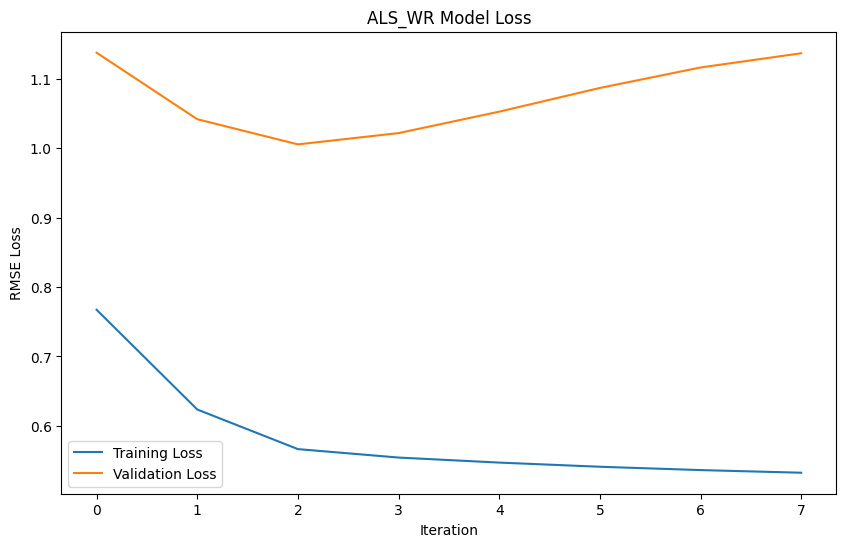

In [199]:
# Initialize UserItemMatrix instance
uim = UserItemMatrix(training_path, movie_path, sparse=True)

# perform a grid_search, pick the best hyperparameters, store the validation and training loss
results = []
for reg_param in [0.1, 0.2]:
    for n_factors in [5, 8]:
        als = ALS_WR(uim, factor_dim=n_factors)
        als.fit(n_iter=20, reg_param=reg_param, regularization="weighted", validation_path=validation_path, patience = 5)
        training_loss = als.get_loss()
        validation_loss = als.get_validation_loss()
        best_loss = als.get_best_loss()
        results.append([reg_param, n_factors, training_loss, validation_loss, best_loss])

# select best model as the one with the smallest validation loss
results = pd.DataFrame(results, columns=["reg_param", "n_factors", "training_loss", "validation_loss", "best_loss"])
best_model = results.loc[results['best_loss'].idxmin()]

print(f"Best model hyperparameters: reg_param={best_model['reg_param']}, n_factors={best_model['n_factors']}")
print(f"Best model loss: {best_model['best_loss']}")

# plot the training and validation loss for the best model
plt.figure(figsize=(10, 6))
plt.plot(best_model['training_loss'], label='Training Loss')
plt.plot(best_model['validation_loss'], label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('RMSE Loss')
plt.title('ALS_WR Model Loss')
plt.legend()
plt.show()

# ALS with PySpark

We now test the algorithm using on the MovieLens 100k dataset. We will perform cross validation to identify the best hyperparameters.

In [9]:
# Create a Spark session
spark = SparkSession.builder.appName('recommender').getOrCreate()

# Load the data
data = spark.read.csv(data_path + 'ratings.csv', inferSchema=True, header=True)

# Split the data
(training, test) = data.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
als = ALS(maxIter=10, userCol='userId', itemCol='movieId', ratingCol='rating', coldStartStrategy='drop')

# We use a ParamGridBuilder to construct a grid of parameters to search over.
# We will try all combinations of values and determine best model using
# the evaluator.
param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [100, 150, 200]) \
    .addGrid(als.regParam, [.05, .1]) \
    .build()

# Define evaluator as RMSE
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

# Build CrossValidator
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5, parallelism=8)

# Fit ALS model to training data
model = cv.fit(training)

# Extract best model from the tuning
best_model = model.bestModel

# Generate predictions and evaluate using RMSE
predictions = best_model.transform(test)
rmse = evaluator.evaluate(predictions)

# Print evaluation metrics and model parameters
print("RMSE = " + str(rmse))
print("**Best Model**")
print(" Rank:", best_model.rank)
print(" MaxIter:", best_model._java_obj.parent().getMaxIter())
print(" RegParam:", best_model._java_obj.parent().getRegParam())


RMSE = 0.8691032268759084
**Best Model**
 Rank: 100
 MaxIter: 10
 RegParam: 0.1


In [10]:
# make top_n recommendations for a user
n = 10
user_id = 1
# get the user's movie ratings
user_ratings = data.filter(data['userId'] == user_id)  
# get the movies the user has rated
rated_movies = user_ratings.select('movieId')
# get the movies the user has not rated
unrated_movies = data.select('movieId').subtract(rated_movies)
# rename the column to userId
unrated_movies = unrated_movies.withColumn('userId', lit(int(user_id)))
# generate predictions
predictions = best_model.transform(unrated_movies)
# get the top n recommendations
top_n = predictions.orderBy('prediction', ascending=False).limit(n)
# get the movie titles
df_movies = spark.read.csv('movies.csv', inferSchema=True, header=True)
# get the movie titles
top_n_titles = top_n.join(df_movies, 'movieId', 'inner').select('title', 'movieId')
# show the recommendations
top_n_titles.show()

+--------------------+-------+
|               title|movieId|
+--------------------+-------+
|Harold and Maude ...|   1235|
|      Yojimbo (1961)|   3030|
|Outlaw Josey Wale...|   3508|
|Victory (a.k.a. E...|   5915|
| Belle époque (1992)|   6442|
|  Saving Face (2004)|  33649|
|Enter the Void (2...|  78836|
|Band of Brothers ...| 170705|
|  Baby Driver (2017)| 171763|
|Three Billboards ...| 177593|
+--------------------+-------+



In [ ]:
# Stop the Spark session
spark.stop()

Rank: 100, RegParam: 0.01, Iteration: 1
Rank: 100, RegParam: 0.01, Iteration: 2
Rank: 100, RegParam: 0.01, Iteration: 3
Rank: 100, RegParam: 0.01, Iteration: 4
Rank: 100, RegParam: 0.01, Iteration: 5
Rank: 100, RegParam: 0.01, Iteration: 6
Rank: 100, RegParam: 0.01, Iteration: 7
Rank: 100, RegParam: 0.01, Iteration: 8
Rank: 100, RegParam: 0.05, Iteration: 1
Rank: 100, RegParam: 0.05, Iteration: 2
Rank: 100, RegParam: 0.05, Iteration: 3
Rank: 100, RegParam: 0.05, Iteration: 4
Rank: 100, RegParam: 0.05, Iteration: 5
Rank: 100, RegParam: 0.05, Iteration: 6
Rank: 100, RegParam: 0.05, Iteration: 7
Rank: 100, RegParam: 0.05, Iteration: 8
Rank: 150, RegParam: 0.01, Iteration: 1
Rank: 150, RegParam: 0.01, Iteration: 2
Rank: 150, RegParam: 0.01, Iteration: 3
Rank: 150, RegParam: 0.01, Iteration: 4
Rank: 150, RegParam: 0.01, Iteration: 5
Rank: 150, RegParam: 0.01, Iteration: 6
Rank: 150, RegParam: 0.01, Iteration: 7
Rank: 150, RegParam: 0.01, Iteration: 8
Rank: 150, RegParam: 0.05, Iteration: 1


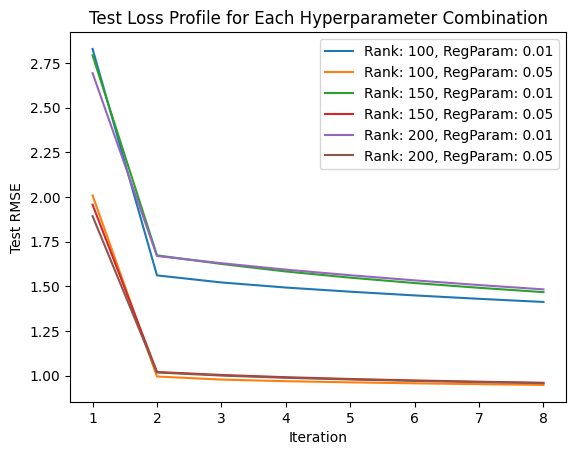

In [15]:
max_iterations = 8
spark = SparkSession.builder.appName('recommender').getOrCreate()
data = spark.read.csv(data_path + 'ratings.csv', inferSchema=True, header=True)
# Split the data
(training, test) = data.randomSplit([0.8, 0.2])

for rank in [100, 150, 200]:
    for regParam in [.01, .05]:
        test_losses = []
        for iteration in range(1, max_iterations + 1):
            print(f'Rank: {rank}, RegParam: {regParam}, Iteration: {iteration}')
            # Train the model for 'iteration' number of iterations
            np.random.seed(42) # always with the same seed
            als = ALS(maxIter=iteration, rank=rank, regParam=regParam,
                      userCol='userId', itemCol='movieId', ratingCol='rating', 
                      coldStartStrategy='drop')
            model = als.fit(training)
            evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
            
            # Evaluate the model on the test set
            predictions = model.transform(test)
            # predictions = predictions.dropna(subset=['prediction'])
            rmse = evaluator.evaluate(predictions)
            test_losses.append(rmse)
        
        # Plot the test loss profile for the current hyperparameter combination
        plt.plot(range(1, max_iterations + 1), test_losses, label=f'Rank: {rank}, RegParam: {regParam}')

# close spark
spark.stop()

plt.xlabel('Iteration')
plt.ylabel('Test RMSE')
plt.title('Test Loss Profile for Each Hyperparameter Combination')
plt.legend()
plt.show()